In [2]:
!pip install gradio

In [3]:
# Import libraries

import os
import cv2
import numpy as np
import tensorflow as tf
import gradio as gr
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

2025-06-05 14:53:55.907927: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749135236.082078      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749135236.136509      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
cat_folder = '/kaggle/input/dog-and-cat-classification-dataset/PetImages/Cat'
dog_folder = '/kaggle/input/dog-and-cat-classification-dataset/PetImages/Dog'

# Example: listing a few files
print("Cat files:", os.listdir(cat_folder)[:5])
print("Dog files:", os.listdir(dog_folder)[:5])

Cat files: ['7981.jpg', '6234.jpg', '1269.jpg', '3863.jpg', '6241.jpg']
Dog files: ['7981.jpg', '6234.jpg', '1269.jpg', '3863.jpg', '6241.jpg']


In [5]:
# Set image dimensions and batch size
img_size = (224, 224)
batch_size = 32

# Dataset base directory (adjust only if yours is different)
base_dir = '/kaggle/input/dog-and-cat-classification-dataset/PetImages'

In [6]:
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)
print("ImageDataGenerator created")

ImageDataGenerator created


In [7]:
# Training data generator
train_generator = datagen.flow_from_directory(
    base_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    subset='training'         # Use 80% of data for training
)

# Validation data generator
val_generator = datagen.flow_from_directory(
    base_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    subset='validation'       # Use 20% of data for validation
)

Found 20000 images belonging to 2 classes.
Found 4998 images belonging to 2 classes.


In [8]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(224, 224, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')  # Binary output: cat or dog
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1749135332.102711      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1749135332.103487      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      44,302,848 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 44,396,609 (169.36 MB)

 Trainable params: 44,396,609 (169.36 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    verbose=2
)

Epoch 1/10


I0000 00:00:1749135342.401232     128 service.cc:148] XLA service 0x7f9840003c20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1749135342.401973     128 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1749135342.401995     128 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1749135342.753606     128 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1749135347.229009     128 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


625/625 - 189s - 303ms/step - accuracy: 0.6564 - loss: 0.6368 - val_accuracy: 0.7237 - val_loss: 0.5373
Epoch 2/10
625/625 - 62s - 99ms/step - accuracy: 0.7630 - loss: 0.4902 - val_accuracy: 0.7539 - val_loss: 0.5155
Epoch 3/10
625/625 - 62s - 100ms/step - accuracy: 0.8206 - loss: 0.3935 - val_accuracy: 0.8063 - val_loss: 0.4149
Epoch 4/10
625/625 - 63s - 101ms/step - accuracy: 0.8882 - loss: 0.2654 - val_accuracy: 0.8023 - val_loss: 0.4632
Epoch 5/10
625/625 - 63s - 101ms/step - accuracy: 0.9542 - loss: 0.1216 - val_accuracy: 0.8025 - val_loss: 0.6191
Epoch 6/10
625/625 - 62s - 99ms/step - accuracy: 0.9870 - loss: 0.0430 - val_accuracy: 0.7955 - val_loss: 0.8894
Epoch 7/10
625/625 - 67s - 106ms/step - accuracy: 0.9913 - loss: 0.0301 - val_accuracy: 0.7997 - val_loss: 1.1232
Epoch 8/10
625/625 - 64s - 103ms/step - accuracy: 0.9918 - loss: 0.0257 - val_accuracy: 0.8005 - val_loss: 1.1103
Epoch 9/10
625/625 - 68s - 109ms/step - accuracy: 0.9940 - loss: 0.0199 - val_accuracy: 0.7965 - val

In [10]:
loss, accuracy = model.evaluate(val_generator, verbose=2)
print(f"Validation Loss: {loss:.4f}")
print(f"Validation Accuracy: {accuracy:.4f}")

157/157 - 11s - 72ms/step - accuracy: 0.7977 - loss: 1.1367
Validation Loss: 1.1367
Validation Accuracy: 0.7977


In [12]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [14]:
cm = confusion_matrix(true_labels, pred_labels)

print("Confusion Matrix:")
print(cm)

# Optional: classification report
print("\nClassification Report:")
print(classification_report(true_labels, pred_labels, target_names=["Cat", "Dog"]))


Confusion Matrix:
[[1214 1285]
 [1264 1235]]

Classification Report:
              precision    recall  f1-score   support

         Cat       0.49      0.49      0.49      2499
         Dog       0.49      0.49      0.49      2499

    accuracy                           0.49      4998
   macro avg       0.49      0.49      0.49      4998
weighted avg       0.49      0.49      0.49      4998



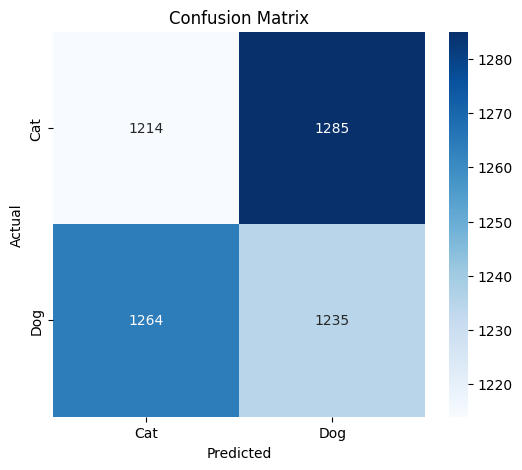

In [16]:
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Cat", "Dog"], yticklabels=["Cat", "Dog"])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [17]:
def predict_cat_dog(img):
    # Preprocess the image
    img = cv2.resize(img, (224, 224))
    img = img / 255.0
    img = np.expand_dims(img, axis=0)

    # Make the prediction
    prediction = model.predict(img)

    # Interpret the prediction
    if prediction > 0.5:
        return "Prediction: Cat"
    else:
        return "Prediction: Dog"


# Create the Gradio interface
iface = gr.Interface(
    fn=predict_cat_dog,          # The function to call for prediction
    inputs=gr.Image(type="numpy"), # Input component: Image upload, passed as a NumPy array
    outputs="text",              # Output component: Text to display the prediction
    title="Cat and Dog Image Classifier",
    description="Upload an image to classify it as a cat or a dog."
)

# Launch the interface
iface.launch(inline=True)

* Running on local URL:  http://127.0.0.1:7860
It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

* Running on public URL: https://115243e932110d3f50.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
